In [4]:
from keras.applications import VGG16
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

import numpy as np
import os

import matplotlib.pyplot as plt

# 1. Define Input Parameters

In [61]:
# vgg was designed to work on 224X224 input image
img_rows, img_cols = (224, 224)

# define number of classes in data
num_classes = 17

# define batch size
batch_size = 32

# 2. Load Data

In [76]:
train_images_dir = '17_flowers/train'
test_images_dir = '17_flowers/validation'

# Define image data generators
# perform image augmentation to save model from overfitting the training data
# augmentation will create various batches of images & will apply various transformations on images like flipping
# hence providing the overall more training data without adding anymore images
# shear_range & zoom_range are to define how much randomization we want to apply on data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=45,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# target size: same as input shape in classifier as this will be the input to classifier
# batch_size: number of inputs after which weights will be updated
# class_mode: ['binary', 'categorical']
training_set = train_datagen.flow_from_directory(train_images_dir,
                                                target_size = (img_rows, img_cols),
                                                batch_size = batch_size,
                                                class_mode = 'categorical',
                                                seed=67)

test_set = test_datagen.flow_from_directory(test_images_dir,
                                            target_size = (img_rows, img_cols),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')

Found 1190 images belonging to 17 classes.
Found 170 images belonging to 17 classes.


# 3. Setup the Model

In [77]:
# 1. load the mobileNet model without the top layer so that we can add custom layers in the end as per our data
vgg16 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape = (img_rows, img_cols, 3))
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [78]:
# 2. freeze the layers of model
for layer in vgg16.layers:
    layer.trainable = False
    
# print the layer names
for i, layer in enumerate(vgg16.layers):
    print(str(i)+" "+layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [79]:
# 3. Add custom layers as per data
x = vgg16.output
flat1 = Flatten()(x)
dense1 = Dense(1024, activation="relu")(flat1)
drop1 = Dropout(0.3)(dense1)
dense2 = Dense(1024, activation="relu")(drop1)
drop2 = Dropout(0.3)(dense2)
dense3 = Dense(num_classes, activation="softmax")(drop2)

model = Model(inputs=vgg16.inputs, output=dense3)
model.compile(optimizer = Adam(lr=0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


# 4. Define other model parameters

In [80]:
checkpoint = ModelCheckpoint('flower17.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1
                            )

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor = 0.2,
                              min_delta=0.0001,
                              patience=3,
                              verbose=1)

# 5. Fitting the model

In [81]:
history = model.fit_generator(training_set,
                              steps_per_epoch = 1190//batch_size,
                              epochs = 25,
                              validation_data = test_set,
                              validation_steps = 170//batch_size,
                              callbacks=[checkpoint, earlystop, reduce_lr])

Epoch 1/25
37/37 [==============================] - 31s 831ms/step - loss: 5.6862 - acc: 0.1275 - val_loss: 2.1803 - val_acc: 0.3312

Epoch 00001: val_loss improved from inf to 2.18028, saving model to flower17.h5
Epoch 2/25
37/37 [==============================] - 22s 596ms/step - loss: 2.1834 - acc: 0.2823 - val_loss: 1.5617 - val_acc: 0.4783

Epoch 00002: val_loss improved from 2.18028 to 1.56167, saving model to flower17.h5
Epoch 3/25
37/37 [==============================] - 27s 717ms/step - loss: 1.8180 - acc: 0.4172 - val_loss: 1.1071 - val_acc: 0.7029

Epoch 00003: val_loss improved from 1.56167 to 1.10707, saving model to flower17.h5
Epoch 4/25
37/37 [==============================] - 26s 713ms/step - loss: 1.5761 - acc: 0.4890 - val_loss: 0.8830 - val_acc: 0.7609

Epoch 00004: val_loss improved from 1.10707 to 0.88303, saving model to flower17.h5
Epoch 5/25
37/37 [==============================] - 27s 742ms/step - loss: 1.4066 - acc: 0.5433 - val_loss: 0.7409 - val_acc: 0.7319

# 6. Predictions

Predicted Class: bluebell
Actual Class: bluebell


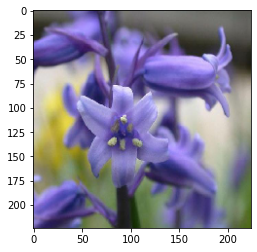

Predicted Class: colts_foot
Actual Class: colts_foot


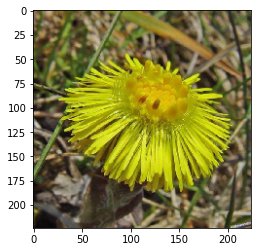

Predicted Class: buttercup
Actual Class: buttercup


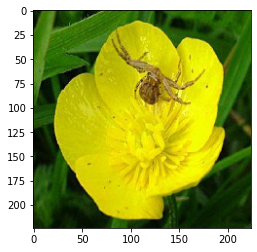

Predicted Class: daisy
Actual Class: daisy


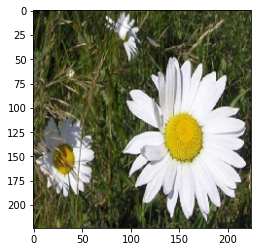

Predicted Class: snowdrop
Actual Class: snowdrop


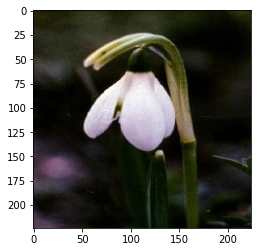

Predicted Class: pansy
Actual Class: crocus


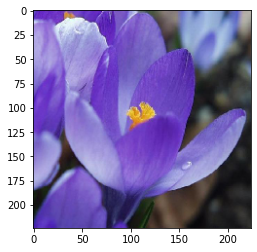

Predicted Class: cowslip
Actual Class: cowslip


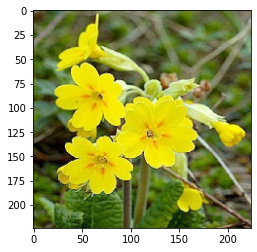

Predicted Class: dandelion
Actual Class: dandelion


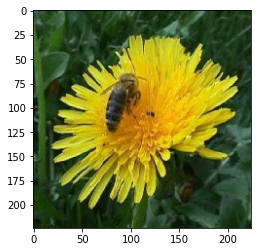

Predicted Class: lily_valley
Actual Class: lily_valley


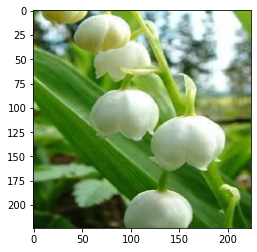

Predicted Class: iris
Actual Class: iris


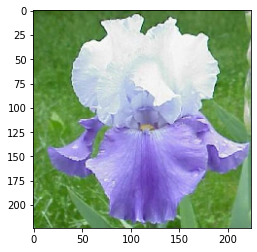

Predicted Class: fritillary
Actual Class: fritillary


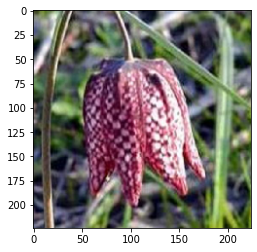

Predicted Class: daffodil
Actual Class: daffodil


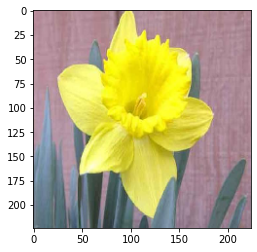

Predicted Class: pansy
Actual Class: pansy


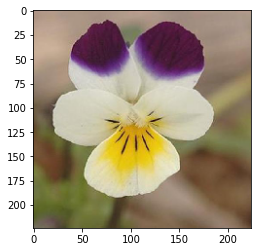

Predicted Class: windflower
Actual Class: windflower


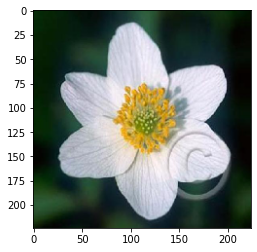

Predicted Class: tigerlily
Actual Class: tigerlily


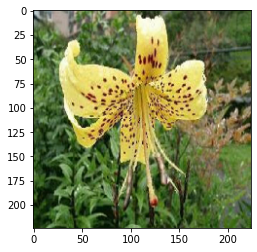

Predicted Class: daffodil
Actual Class: tulip


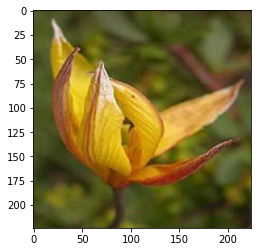

Predicted Class: sunflower
Actual Class: sunflower


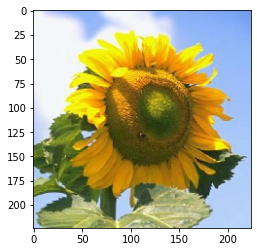

In [82]:
# get all classes folder names
image_folders = os.listdir(test_images_dir)
for i in range(17):
    # choose one random folder (0, 9)
    folder_index = i

    # get all images in the specified folder
    val_images = os.listdir(os.path.join(test_images_dir, image_folders[folder_index]))
    index = 5

    # load image
    test_image = image.load_img(os.path.join(test_images_dir, image_folders[folder_index]+'/'+val_images[index]), target_size=(img_cols, img_rows))
    plt.imshow(test_image, interpolation='bilinear')
    # convert into array
    # dimension = 224, 224, 3
    test_image = image.img_to_array(test_image)
    # add batch size as 4th dimension
    test_image = np.expand_dims(test_image, axis = 0)
    # predict on rescaled image
    result = model.predict(test_image/255)

    # get class indices
    class_labels = {v:k for k,v in training_set.class_indices.items()}

    # get class attributes
    print('Predicted Class:', class_labels[np.argmax(result)])
    print('Actual Class:', image_folders[folder_index])
    plt.show()